# Snowflake Warehouse Reports Using Snowflake Snowpark

<blockquote>
    Calling Configuration Notebook at #1
    <br>Establishing Connection To Snowflake 
    <br>Generating Warehouse Cost Matrix From Snowflake
    <br>Sending an Customized Alert
</blockquote>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.ticker as ticker

In [1]:
%run ./sf_config.ipynb

In [2]:
conn = Session.builder.configs(conn_config).create()

In [43]:
#Using Snowpark Session SQL To Query Warehouse Credits Consumption in last 30 Days

sp_warehouse_consumption = conn.sql("WITH CTE_DATE_WH AS(  \
  SELECT TO_DATE(START_TIME) AS START_DATE \
        ,WAREHOUSE_NAME \
        ,SUM(CREDITS_USED) AS CREDITS_USED_DATE_WH \
    FROM SNOWFLAKE.ACCOUNT_USAGE.WAREHOUSE_METERING_HISTORY \
   GROUP BY START_DATE \
           ,WAREHOUSE_NAME \
) \
SELECT START_DATE \
      ,WAREHOUSE_NAME \
      ,round(CREDITS_USED_DATE_WH) AS CREDITS_USED_DATE_WH \
  FROM CTE_DATE_WH \
where CREDITS_USED_DATE_WH > 0  \
AND START_DATE > DATEADD(Month,-1,CURRENT_TIMESTAMP())")

pd_warehouse_consumption = sp_warehouse_consumption.to_pandas()

pd_warehouse_consumption

,START_DATE,WAREHOUSE_NAME,CREDITS_USED_DATE_WH
0,2023-03-14,COMPUTE_WH,0
1,2023-03-04,COMPUTE_WH,1
2,2023-02-27,COMPUTE_WH,4
3,2023-03-12,COMPUTE_WH,0
4,2023-02-26,COMPUTE_WH,2
5,2023-03-06,COMPUTE_WH,0
6,2023-02-25,COMPUTE_WH,0
7,2023-03-08,COMPUTE_WH,1


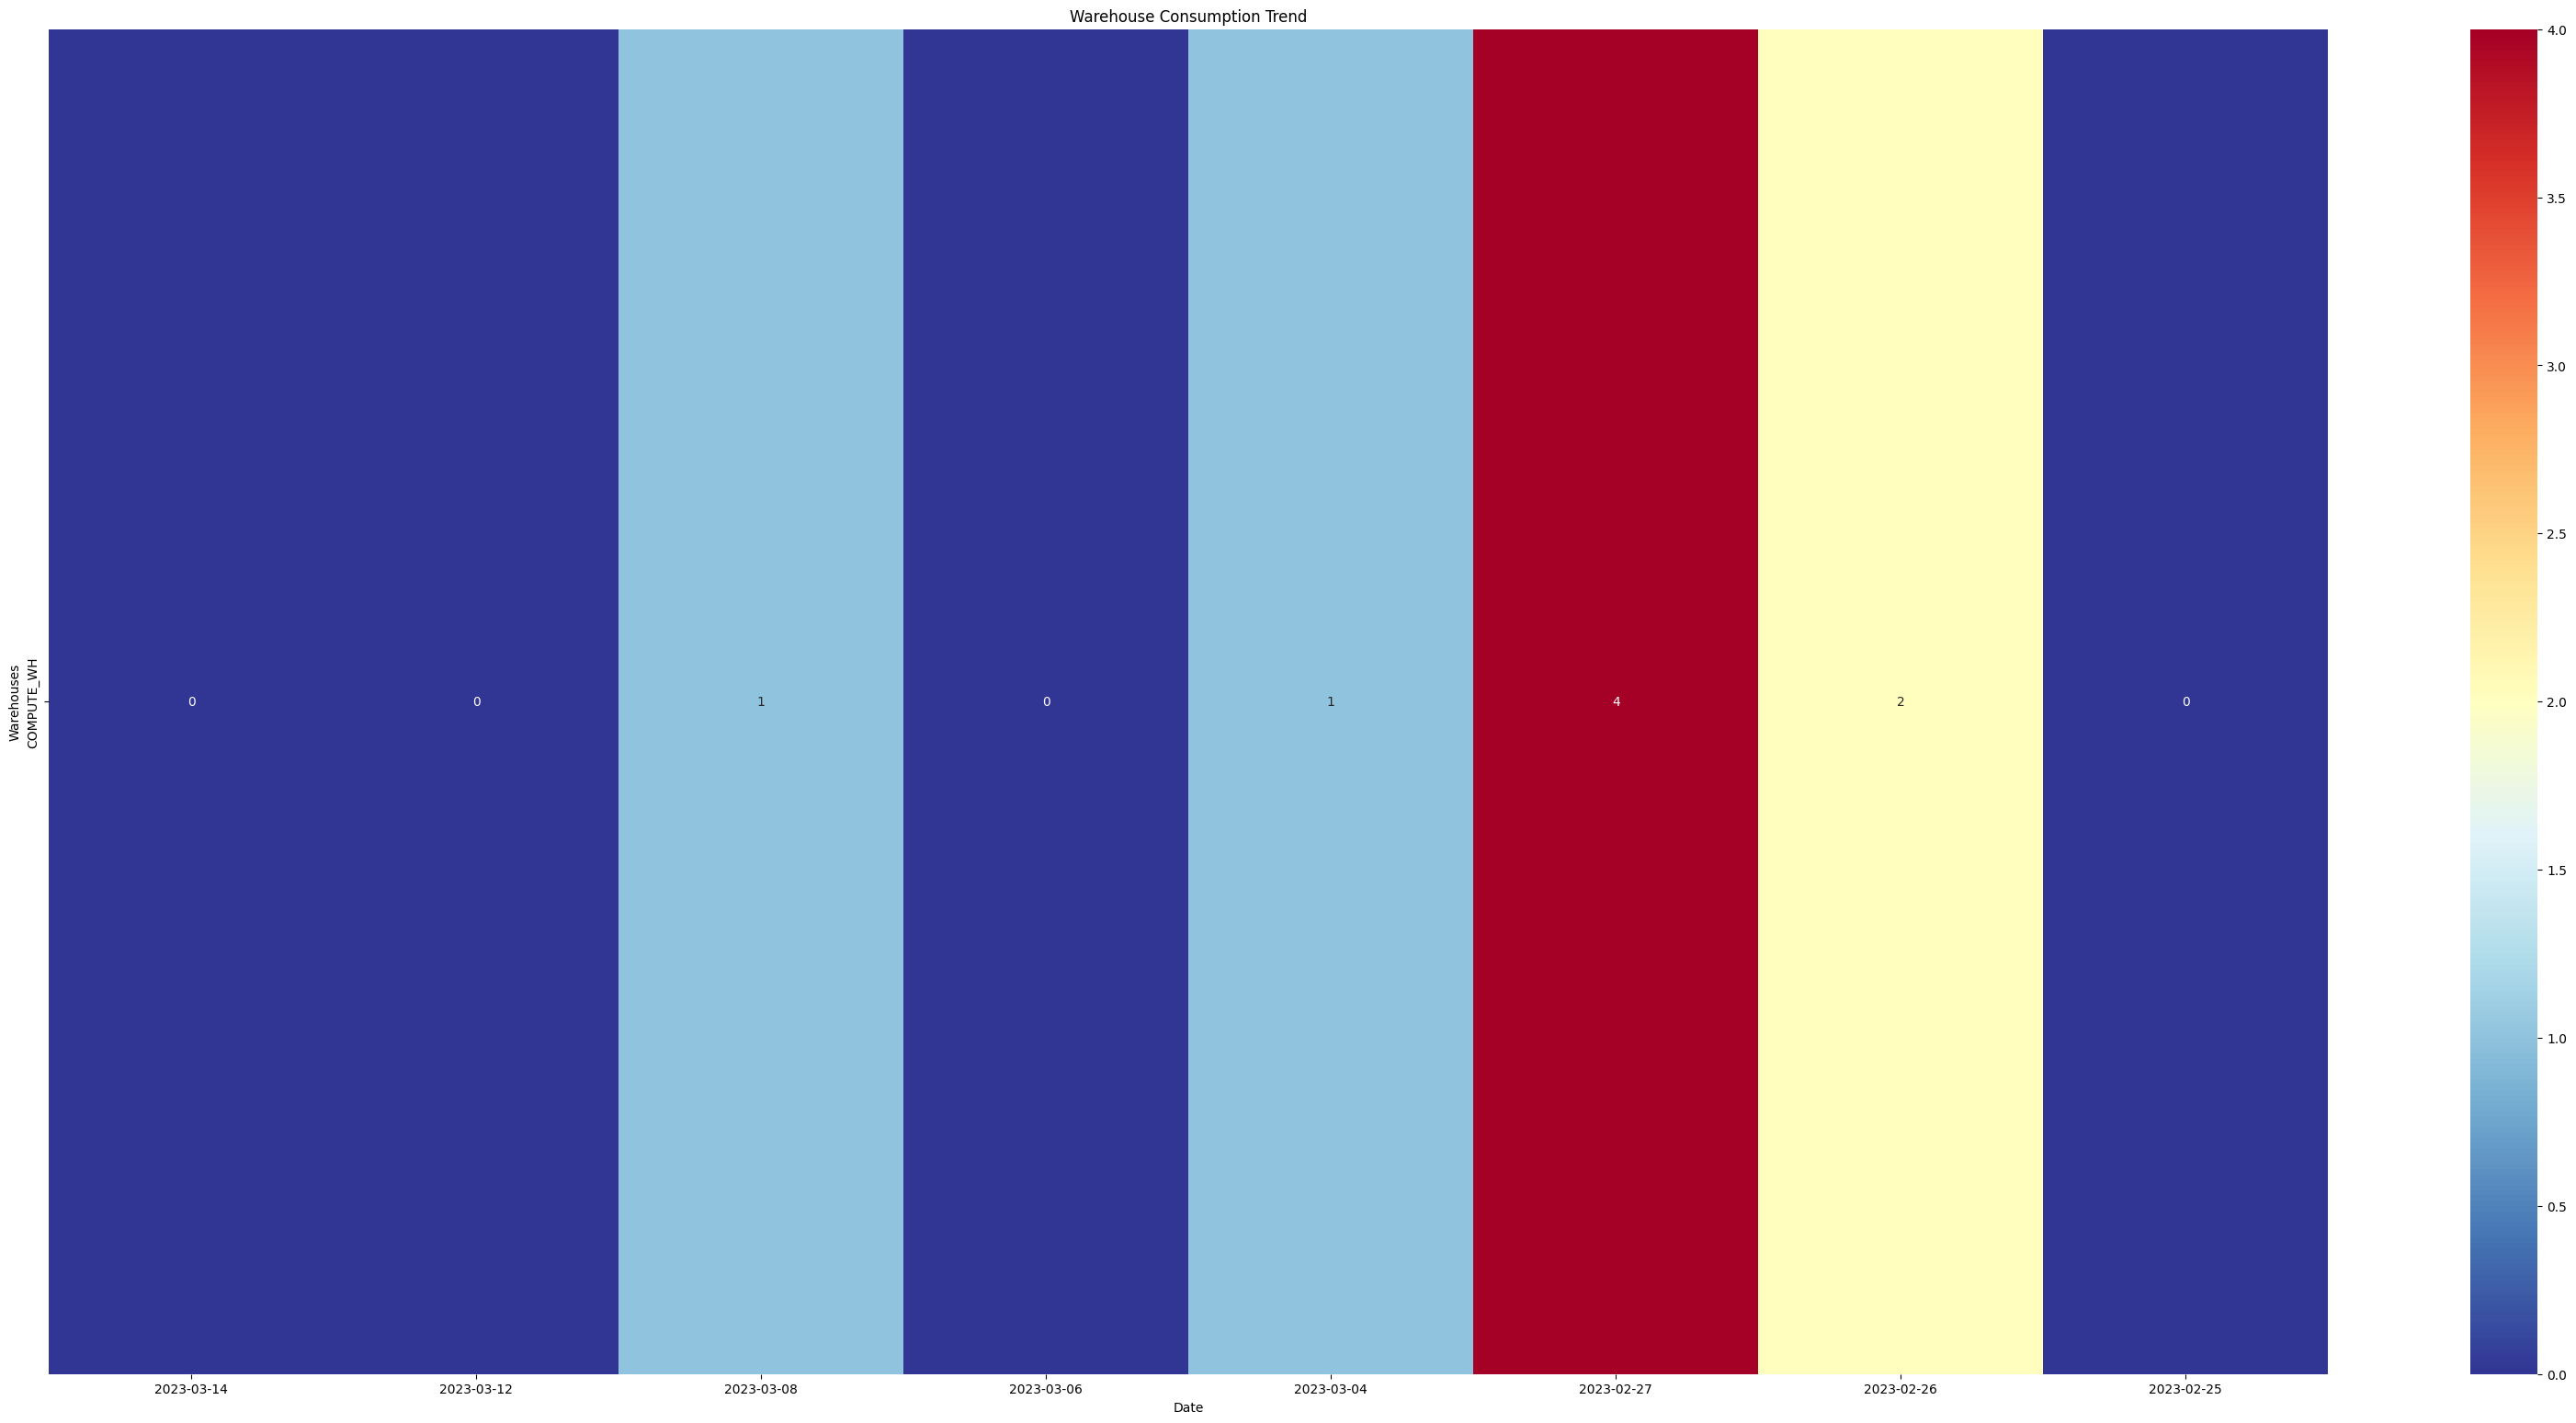

In [56]:
df_pivot = pd.pivot_table(pd_warehouse_consumption
                          ,values='CREDITS_USED_DATE_WH'
                          ,index='WAREHOUSE_NAME'
                          ,columns='START_DATE')
df_pivot
plt.figure(figsize=(40,19))
plt.title('Warehouse Consumption Trend')
a = sns.heatmap(df_pivot,annot=True,cmap='RdYlBu_r',fmt='.4g',)
a.invert_xaxis()
a.invert_yaxis()
plt.xlabel('Date')
plt.ylabel('Warehouses')
plt.show()
a.figure.savefig('img.jpg',bbox_inches = 'tight')


In [58]:
path1 = "img.jpg"
template_css_header = """
<html>
   <head>
         <style>
         p{
         width:50%;}
           table {
    border-collapse: collapse;
  }
  th, td {
    border: 1px solid black;
    padding: 5px;
    text-align: left;
  }
      </style>

   </head>
"""

template_end_footer = """
      </table>
      <br>
 <br>
      <hr/>
   </body>
</html>
"""

template_warehouse_usage = """
   <body>
      <H2>AC Snowflake Production Warehouse Usage and Query Profiling Report</H2>
      <hr>
      <IMG SRC = 'cid:{current_dupe_graph}' ></img>
      <br>
      <br>
""".format(current_dupe_graph = path1 )
template = template_css_header +template_warehouse_usage + template_end_footer



In [60]:
import datetime
import email.message, smtplib, re
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage

dat = datetime.datetime.now().strftime("%Y-%m-%d")
mail_subject = "Snowflake WH Usage and Query Profiling Daily Report - " + dat

msg = email.message.EmailMessage()
msg = MIMEMultipart()
msg["To"] = "divyanshsaxenaofficial@gmail.com"
msg["Cc"] = "divyanshsaxenaofficial@gmail.com"
msg["From"] = "divyanshsaxenaofficial@gmail.com"
msg["Subject"] = mail_subject
body = template
msgText = MIMEText(body, 'html')  
msg.attach(msgText)

#EMBEDDING THE PNG GRAPH IMAGES IN EMAIL
#**********************************************************************************************

with open(path1, 'rb') as fp:
    img = MIMEImage(fp.read())
img.add_header('Content-ID', '<{}>'.format(path1))
msg.attach(img)


#**********************************************************************************************

server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.SentOnBehalfOfName = "divyanshsaxenaofficial@gmail.com"
server.login("divyanshsaxenaofficial@gmail.com", 'wgmvnrmtoctwaupv')
server.send_message(msg)
server.quit()

(221,
 b'2.0.0 closing connection j11-20020a65428b000000b004d4547cc0f7sm4368761pgp.18 - gsmtp')